In [1]:
from scipy.stats import shapiro
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_csv('./df_clusters_consolidation_s1_.csv')
df.head()

In [ ]:
df=df.drop(columns=['Id'])

In [ ]:
notasDiscretizadas=[]
for elemento in df['finalGrade']:
    if (elemento>=0.5):
        notasDiscretizadas+=[1]
    else:
        notasDiscretizadas+=[0]

In [ ]:
df['finalGrade']=notasDiscretizadas
#df=df.drop(columns='finalGrade')
df.head()

In [ ]:
X = df.iloc[:,:-1].values
y = df.iloc[:,-1].values

In [ ]:
from imblearn.under_sampling import ClusterCentroids

# cc = ClusterCentroids()
# X, y = cc.fit_sample(X, y)
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, sampling_strategy='majority')
X, y, id_tl = tl.fit_sample(X, y)

In [2]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier 
from sklearn import metrics

In [ ]:
from sklearn.model_selection import StratifiedKFold
vetor_X_train=[]
vetor_y_train=[]
vetor_X_test=[]
vetor_y_test=[]
split = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
for train_index, val_index in split.split(X, y):
    vetor_X_train+=[X[train_index]]
    vetor_X_test+=[X[val_index]]
    vetor_y_train+=[y[train_index]]
    vetor_y_test+=[y[val_index]]

In [ ]:
semente=0
dataLgbAuc=[]
dataLgbPrecision=[]
dataLgbRecall=[]
dataLgbF1=[]
while(semente<100):
    params = {
    "num_leaves": 100,
    "verbose": -1,
    "min_data": 100,
    "max_bin": 1024,
    "learning_rate": 0.055,
    "boosting_type": "gbdt",
    "boost_from_average": True,
    "metric": "binary_logloss",
    "max_features":0.3,
    "n_estimators":100,
    "bootstrap":True, 
    "criterion":"gini", 
    "min_samples_leaf":11, 
    "min_samples_split":8,
    "random_state":semente
    }
    contador=0
    pred=[]
    true=[]
    while(contador<len(vetor_X_train)):
        X_train=vetor_X_train[contador]
        y_train=vetor_y_train[contador]
        X_test=vetor_X_test[contador]
        y_test=vetor_y_test[contador]


    #     X_train, y_train,a = tl.fit_sample(X_train, y_train)

        d_train = lgb.Dataset(X_train, label=y_train)
        d_test = lgb.Dataset(X_test, label=y_test)


        model = lgb.train(params, d_train, 10000, valid_sets=[d_test], early_stopping_rounds=100, verbose_eval=1000)
        ypred = model.predict(X_test)
        ypred = np.where(ypred<0.5,0,1)
               
        dataLgbF1+=[metrics.f1_score(y_test,ypred)]
        dataLgbRecall+=[metrics.recall_score(y_test,ypred)]
        dataLgbPrecision+=[metrics.precision_score(y_test,ypred)]
        dataLgbAuc+=[metrics.accuracy_score(y_test,ypred)]
        
        contador+=1
    
    semente+=1

In [3]:
import os
PATH = 'Replicacao SBIE - data and code/Programming Profile v4/tabelas_por_lista'
years = os.listdir(PATH)

In [4]:
dfs = []
for year in years:
    aux = pd.read_csv(os.path.join(PATH,year,'s1.csv'))
    #aux.drop(['blank_line', 'lloc', 'error', 'watson'], axis=1, inplace=True)
    aux.drop(['blank_line', 'lloc', 'error'], axis=1, inplace=True)
    dfs.append(aux)

In [5]:
df = pd.concat(dfs)

In [6]:
df.loc[df.copy_paste_proportion>5, 'copy_paste_proportion'] = 5

In [7]:
total_unique_ids = df.Id.unique().size
print('Total Students: ', (df.shape[0]))
print('Total Unique Students: ', (total_unique_ids))
print('Total Repetents Students: ', (df.shape[0] - total_unique_ids))

Total Students:  2058
Total Unique Students:  1655
Total Repetents Students:  403


In [8]:
df['class'] = pd.cut(df.Media_final, bins=[0., 4.9999, 10.], right=True, labels=[0, 1], include_lowest=True)

In [9]:
df['class'] = df['class'].astype('int')

In [10]:
features = df.drop(['Id', 'Media_final', 'class', 'submission_per_exercise','cont_condition', 'cont_cicle',
           'sucess_average', 'test_average', 'copy_paste_proportion', 'sintaxe_error'], axis=1).columns.to_list()

In [11]:
X, y = df.drop(['Id', 'Media_final', 'class', 'submission_per_exercise','cont_condition', 'cont_cicle',
               'sucess_average', 'test_average', 'copy_paste_proportion', 'sintaxe_error'], axis=1).values, df['class'].values

In [12]:
from sklearn.model_selection import StratifiedKFold
vetor_X_train=[]
vetor_y_train=[]
vetor_X_test=[]
vetor_y_test=[]
split = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)
for train_index, val_index in split.split(X, y):
    vetor_X_train+=[X[train_index]]
    vetor_X_test+=[X[val_index]]
    vetor_y_train+=[y[train_index]]
    vetor_y_test+=[y[val_index]]

In [24]:
semente=0
dataRFAuc=[]
dataRFPrecision=[]
dataRFRecall=[]
dataRFF1=[]
while(semente<20):
    contador=0
    while(contador<len(vetor_X_train)):
        X_train=vetor_X_train[contador]
        y_train=vetor_y_train[contador]
        X_test=vetor_X_test[contador]
        y_test=vetor_y_test[contador]

        model = RandomForestClassifier(bootstrap=True, criterion="gini", max_features=0.3, min_samples_leaf=11, min_samples_split=8, n_estimators=100,random_state=semente)
        model.fit(X_train,y_train)
        ypred = model.predict(X_test)
               
        dataRFF1+=[metrics.f1_score(y_test,ypred)]
        dataRFRecall+=[metrics.recall_score(y_test,ypred)]
        dataRFPrecision+=[metrics.precision_score(y_test,ypred)]
        dataRFAuc+=[metrics.accuracy_score(y_test,ypred)]
        
        contador+=1
    
    semente+=1

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [15]:
df=pd.read_csv('./NewBaseS1')
df = df.drop(columns=['Id'])
X = df.iloc[:,:-2].values
y = df.iloc[:,-1].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
sc = MinMaxScaler()
X = sc.fit_transform(X)

In [ ]:
X = np.array(X)
y = np.array(y)

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(return_indices=True, sampling_strategy='majority')

In [ ]:
X, y, id_tl = tl.fit_sample(X, y)

In [ ]:
from sklearn.model_selection import StratifiedKFold


In [ ]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(y)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer                    
from keras.preprocessing.sequence import pad_sequences
from keras import layers

In [ ]:
def baseline_model():
    
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(25,)))
    model.add(Dropout(p=0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(p=0.5))
    model.add(layers.Dense(2, activation='sigmoid'))


    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
from sklearn import metrics

In [ ]:
contador=0
predictions=[]
semente = 15
dataLgbAuc=[]
dataLgbPrecision=[]
dataLgbRecall=[]
dataLgbF1=[]
num = 150
while(semente < 100):
    contador = 0
    vetor_X_train=[]
    vetor_y_train=[]
    vetor_X_test=[]
    vetor_y_test=[]
    split = StratifiedKFold(n_splits=10, random_state=semente, shuffle=True)
    for train_index, val_index in split.split(X, y):
        vetor_X_train+=[X[train_index]]
        vetor_X_test+=[X[val_index]]
        vetor_y_train+=[y[train_index]]
        vetor_y_test+=[y[val_index]]
        
    while(contador<len(vetor_X_train)):
        X_train=vetor_X_train[contador]
        y_train=vetor_y_train[contador]
        X_test=vetor_X_test[contador]
        y_test=vetor_y_test[contador]

        encoded_y = encoder.transform(y_train)
        y_train = np_utils.to_categorical(encoded_y)

        estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=30)
        estimator.fit(X_train, y_train)
        y_pred = encoder.inverse_transform(estimator.predict(X_test))
        predictions+=[y_pred]
          
        np.savetxt('./resultDL/ytest'+str(num), y_test, fmt='%s')
        np.savetxt('./resultDL/ypred'+str(num), y_pred, fmt='%s')
        num+=1


        contador+=1
    semente+=1


In [25]:
contador = 0
dataLgbAuc=[]
dataLgbPrecision=[]
dataLgbRecall=[]
dataLgbF1=[]
while(contador < 200):
    true = open('./resultDL/ytest'+str(contador))
    y_test = []
    for linha in true:
        y_test +=[int(linha)]
        
    pred = open('./resultDL/ypred'+str(contador))
    ypred = []
    for linha in pred:
        ypred +=[int(linha)]
        
    dataLgbF1+=[metrics.f1_score(y_test,ypred)]
    dataLgbRecall+=[metrics.recall_score(y_test,ypred)]
    dataLgbPrecision+=[metrics.precision_score(y_test,ypred)]
    dataLgbAuc+=[metrics.accuracy_score(y_test,ypred)]
    
    contador +=1

In [26]:
d = {
    'acc':[dataRFAuc, dataLgbAuc],
    'f1':[dataRFF1, dataLgbF1],
    'recall':[dataRFRecall, dataLgbRecall],
    'precision':[dataRFPrecision, dataLgbPrecision],
}

In [27]:
alpha = 0.05
for metric, performance in d.items():
    _, p1 = shapiro(performance[0])
    _, p2 = shapiro(performance[1])
    if (p1 > alpha) and (p2 > alpha):
        print(2)
        stat, p = ttest_ind(performance[0], performance[1])
    else:
	    stat, p = mannwhitneyu(performance[0], performance[1])
    print('-------------------')
    print(p)
    print(metric)
    
    if p > alpha:
	    print('Não há diferença estatística (fail to reject H0)')
    else:
	    print('Existe diferença estatística (reject H0)')

-------------------
4.339972975559379e-31
acc
Existe diferença estatística (reject H0)
2
-------------------
3.4992877282006244e-57
f1
Existe diferença estatística (reject H0)
-------------------
8.945244648431878e-31
recall
Existe diferença estatística (reject H0)
-------------------
4.3174455503729174e-32
precision
Existe diferença estatística (reject H0)


In [28]:
df = pd.DataFrame()
for metric,performance in d.items():
    df[metric+'_RF'] = performance[0]
    df[metric+'_DL'] = performance[1]
df.head()

,acc_RF,acc_DL,f1_RF,f1_DL,recall_RF,recall_DL,precision_RF,precision_DL
0,0.762136,0.845361,0.735135,0.827586,0.772727,0.818182,0.701031,0.837209
1,0.781553,0.768041,0.769231,0.759358,0.852273,0.806818,0.700935,0.717172
2,0.713592,0.814433,0.697436,0.802198,0.772727,0.829545,0.635514,0.776596
3,0.839806,0.840206,0.813559,0.832432,0.818182,0.875000,0.808989,0.793814
4,0.776699,0.788660,0.744444,0.785340,0.752809,0.842697,0.736264,0.735294


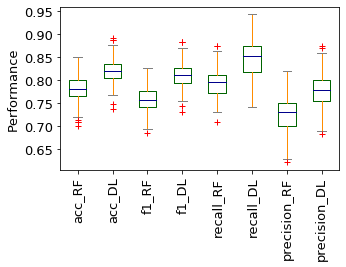

In [29]:
color = {'boxes': 'DarkGreen', 'whiskers': 'DarkOrange', 'medians': 'DarkBlue', 'caps': 'Gray'}
ax = df.plot.box(rot=90, figsize=(5,3), fontsize=13, color=color, sym='r+')
ax.set_ylabel("Performance", fontsize=13);
plt.savefig('resultsNews.pdf', format='pdf',bbox_inches='tight');

In [30]:
df.describe()

,acc_RF,acc_DL,f1_RF,f1_DL,recall_RF,recall_DL,precision_RF,precision_DL
count,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000,200.000000
mean,0.782259,0.819432,0.758762,0.810372,0.795343,0.846442,0.726957,0.778867
std,0.029912,0.024882,0.028527,0.026127,0.031362,0.041968,0.042334,0.033259
min,0.699029,0.737113,0.683673,0.730159,0.707865,0.741573,0.620370,0.683168
25%,0.765777,0.804124,0.740331,0.793562,0.772727,0.818182,0.699029,0.754717
50%,0.781553,0.819588,0.756156,0.811806,0.795455,0.852273,0.731183,0.777778
75%,0.800000,0.835052,0.776747,0.826269,0.811287,0.875000,0.750000,0.800000
max,0.849515,0.891753,0.826816,0.883978,0.875000,0.943820,0.820225,0.873563


In [31]:
df.agg(['mean','std'])

,acc_RF,acc_DL,f1_RF,f1_DL,recall_RF,recall_DL,precision_RF,precision_DL
mean,0.782259,0.819432,0.758762,0.810372,0.795343,0.846442,0.726957,0.778867
std,0.029912,0.024882,0.028527,0.026127,0.031362,0.041968,0.042334,0.033259


In [32]:
newDataframe = [["RandomForest", "Deep Learning", "Method"]]
for i in range(1, 8):
    if (i % 2 != 0):
        aux = []
        for cada in df.iloc[:, i - 1:i + 1].values:
            if (i == 1):
                aux +=[[cada[0], cada[1], "Accuracy"]]
            if (i == 3):
                aux +=[[cada[0], cada[1], "F1-Score"]]
            if (i == 5):
                aux +=[[cada[0], cada[1], "Recall"]]
            if (i == 7):
                aux +=[[cada[0], cada[1], "Precision"]]
        newDataframe +=aux
df = pd.DataFrame(newDataframe)
df.to_csv('correct.csv', header=None, index=None)
df = pd.read_csv("correct.csv")

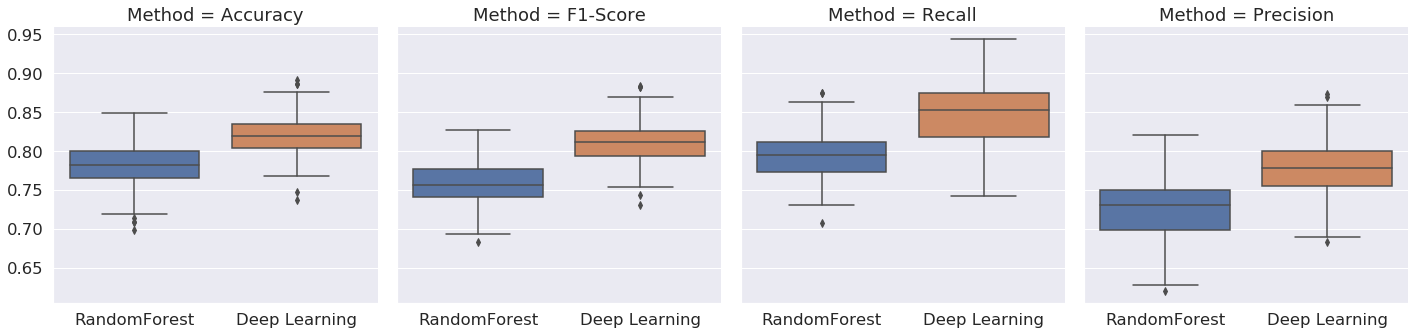

In [60]:
import seaborn as sns
g = sns.catplot(col = df.columns.values[-1],
                kind="box",
                data=df)
sns.set(font_scale = 1.5)